In [14]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, ParameterGrid
from metrics import *

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve

In [15]:
df = pd.read_parquet("xgboost_dataset_ebnerd_small.parquet")
print(len(df))

df

1882518


,session_id,user_id,article_id,clicked,sentiment_score,is_premium_user,readtime_avg
0,4180,526520,9743870,False,0.9466,False,0.0
1,4180,526520,9776386,False,0.9678,False,0.0
2,4180,526520,9776394,False,0.9386,False,0.0
3,4180,526520,9776438,False,0.8330,False,0.0
4,4180,526520,9776442,True,0.9086,False,0.0
...,...,...,...,...,...,...,...
1882513,747086,2110744,9771042,True,0.6719,False,0.0
1882514,747086,2110744,9514481,False,0.9501,False,0.0
1882515,747086,2110744,9440508,False,0.9076,False,0.0
1882516,747086,2110744,9142581,False,0.6342,False,0.0


In [30]:
valid_df = pd.read_parquet("xgboost_dataset_ebnerd_small_valid.parquet")
valid_df = valid_df.sample(frac=0.15, random_state=42)
print(len(valid_df))

valid_df

439341


,session_id,user_id,article_id,clicked,sentiment_score,is_premium_user,readtime_avg
1519854,1423279,1756047,9788547,False,0.9808,False,0.0
2261547,1018594,1541363,9780476,True,0.7987,False,0.0
1802248,480628,670784,9785899,False,0.8229,False,0.0
479510,1808408,1989532,9779674,False,0.9928,False,0.0
1940449,1583098,1575853,9779509,False,0.7415,False,0.0
...,...,...,...,...,...,...,...
2442651,135994,148094,9786217,False,0.9913,False,0.0
396592,392601,1639302,9783850,False,0.5229,False,0.0
86552,528225,753821,9663605,False,0.8602,False,0.0
1621911,838971,2355074,9785888,False,0.8126,False,0.0


In [17]:
def split_by_session(data, test_size=0.2, random_state=42):
    # Get unique sessions
    unique_sessions = data['session_id'].unique()

    # Split sessions into train and test
    train_sessions, test_sessions = train_test_split(unique_sessions,
                                                    test_size=test_size,
                                                    random_state=random_state)

    # Create train and test sets
    train_data = data[data['session_id'].isin(train_sessions)]
    test_data = data[data['session_id'].isin(test_sessions)]

    return train_data, test_data

In [18]:
train_data, test_data = split_by_session(df, test_size = 0.2)


In [31]:
# Prepare validation set
X_valid = valid_df[["sentiment_score", "is_premium_user", "readtime_avg"]].values
y_valid = valid_df['clicked'].values
group_valid = valid_df.groupby('session_id').size().to_list()

In [20]:
'''
# Assertion for training data
for session in train_data['session_id'].unique():
    clicked_values = train_data[train_data['session_id'] == session]['clicked'].unique()
    assert set(clicked_values) == {True, False}, f"Session {session} in train data does not contain both True and False."

# Assertion for testing data
for session in test_data['session_id'].unique():
    clicked_values = test_data[test_data['session_id'] == session]['clicked'].unique()
    assert set(clicked_values) == {True, False}, f"Session {session} in test data does not contain both True and False."

print("All assertions passed. Each session in both train and test data contains both True and False in 'clicked'.")
'''

'\n# Assertion for training data\nfor session in train_data[\'session_id\'].unique():\n    clicked_values = train_data[train_data[\'session_id\'] == session][\'clicked\'].unique()\n    assert set(clicked_values) == {True, False}, f"Session {session} in train data does not contain both True and False."\n\n# Assertion for testing data\nfor session in test_data[\'session_id\'].unique():\n    clicked_values = test_data[test_data[\'session_id\'] == session][\'clicked\'].unique()\n    assert set(clicked_values) == {True, False}, f"Session {session} in test data does not contain both True and False."\n\nprint("All assertions passed. Each session in both train and test data contains both True and False in \'clicked\'.")\n'

In [21]:
train_data.head()

,session_id,user_id,article_id,clicked,sentiment_score,is_premium_user,readtime_avg
0,4180,526520,9743870,False,0.9466,False,0.0
1,4180,526520,9776386,False,0.9678,False,0.0
2,4180,526520,9776394,False,0.9386,False,0.0
3,4180,526520,9776438,False,0.8330,False,0.0
4,4180,526520,9776442,True,0.9086,False,0.0


In [22]:


# Features and labels for training
feature_list = ["sentiment_score","is_premium_user", "readtime_avg"]
X_train = train_data[feature_list].values
y_train = train_data['clicked'].values

X_test = test_data[feature_list].values
y_test = test_data['clicked'].values

# Group (number of articles per session)
group_train = train_data.groupby('session_id').size().to_list()
group_test = test_data.groupby('session_id').size().to_list()


In [32]:
# Convert training data to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtrain.set_group(group_train)

# Convert test data to DMatrix
dtest = xgb.DMatrix(X_test)
dtest.set_group(group_test)

# Convert validation data to DMatrix
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dvalid.set_group(group_valid)

# Set parameters for XGBoost ranking
# params = {
#     'objective': 'rank:pairwise',  # Pairwise ranking objective
#     'eta': 0.1,  # Learning rate
#     'max_depth': 6,  # Max tree depth
#     'eval_metric': 'ndcg'  # Evaluation metric: Normalized Discounted Cumulative Gain
# }
#
# # Train the XGBoost model
# bst = xgb.train(params, dtrain, num_boost_round=500)


In [33]:
# Pretrain model on training data
pretrain_model = xgb.XGBRanker(
    objective='rank:pairwise',
    eval_metric='ndcg',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    colsample_bytree=0.8,
    subsample=0.8
)

pretrain_model.fit(
    X_train,
    y_train,
    group=group_train,
    eval_set=[(X_train, y_train)],
    eval_group=[group_train],
    verbose=True
)

[0]	validation_0-ndcg:0.58458
[1]	validation_0-ndcg:0.59121
[2]	validation_0-ndcg:0.59543
[3]	validation_0-ndcg:0.60021
[4]	validation_0-ndcg:0.60030
[5]	validation_0-ndcg:0.60216
[6]	validation_0-ndcg:0.60216
[7]	validation_0-ndcg:0.60285
[8]	validation_0-ndcg:0.60369
[9]	validation_0-ndcg:0.60369
[10]	validation_0-ndcg:0.60370
[11]	validation_0-ndcg:0.60372
[12]	validation_0-ndcg:0.60372
[13]	validation_0-ndcg:0.60559
[14]	validation_0-ndcg:0.60626
[15]	validation_0-ndcg:0.60627
[16]	validation_0-ndcg:0.60772
[17]	validation_0-ndcg:0.60771
[18]	validation_0-ndcg:0.60772
[19]	validation_0-ndcg:0.60829
[20]	validation_0-ndcg:0.60830
[21]	validation_0-ndcg:0.60830
[22]	validation_0-ndcg:0.60811
[23]	validation_0-ndcg:0.60810
[24]	validation_0-ndcg:0.60877
[25]	validation_0-ndcg:0.60951
[26]	validation_0-ndcg:0.60959
[27]	validation_0-ndcg:0.60960
[28]	validation_0-ndcg:0.60953
[29]	validation_0-ndcg:0.60993
[30]	validation_0-ndcg:0.60995
[31]	validation_0-ndcg:0.61022
[32]	validation_0-

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=0.8, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric='ndcg', feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None, learning_rate=0.1,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=6, max_leaves=None,
          min_child_weight=None, missing=nan, monotone_constraints=None,
          multi_strategy=None, n_estimators=100, n_jobs=None,
          num_parallel_tree=None, objective='rank:pairwise', ...)

In [41]:
# Hyperparameter search on validation set
param_grid = {
    'max_depth': [4, 6, 8],  # Key parameter affecting model complexity
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rates for balance between convergence speed and stability
    'min_child_weight': [1, 5],  # Regularization to prevent overfitting on small datasets
    'n_estimators': [50, 100],  # Number of boosting rounds
    'subsample': [0.8, 1.0],  # Helps with overfitting
    'colsample_bytree': [0.8, 1.0]  # Helps with overfitting
}

best_score = -float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    fine_tune_model = xgb.XGBRanker(**params)

    fine_tune_model.fit(
        X_valid,
        y_valid,
        group=group_valid,
        eval_set=[(X_valid, y_valid)],
        eval_group=[group_valid],
        verbose=False,
        xgb_model=pretrain_model.get_booster()  # Load pretrained model
    )

    y_pred_valid = fine_tune_model.predict(X_valid)
    valid_df['predicted_score'] = y_pred_valid
    ndcg_score = calculate_ndcg(valid_df, k=10)

    if ndcg_score > best_score:
        best_score = ndcg_score
        best_params = params

print("Best Parameters:", best_params)
print("Best Validation NDCG@10:", best_score)

# Train final model with best hyperparameters
final_model = xgb.XGBRanker(**best_params)

final_model.fit(
    X_valid,
    y_valid,
    group=group_valid,
    eval_set=[(X_valid, y_valid)],
    eval_group=[group_valid],
    verbose=True,
    xgb_model=pretrain_model.get_booster()
)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Best Validation NDCG@10: 0.5779050396291792
[0]	validation_0-ndcg:0.90282
[1]	validation_0-ndcg:0.90422
[2]	validation_0-ndcg:0.90546
[3]	validation_0-ndcg:0.90620
[4]	validation_0-ndcg:0.90620
[5]	validation_0-ndcg:0.90692
[6]	validation_0-ndcg:0.90693
[7]	validation_0-ndcg:0.90788
[8]	validation_0-ndcg:0.90850
[9]	validation_0-ndcg:0.90852
[10]	validation_0-ndcg:0.90852
[11]	validation_0-ndcg:0.90853
[12]	validation_0-ndcg:0.90854
[13]	validation_0-ndcg:0.90918
[14]	validation_0-ndcg:0.90963
[15]	validation_0-ndcg:0.90964
[16]	validation_0-ndcg:0.90999
[17]	validation_0-ndcg:0.91000
[18]	validation_0-ndcg:0.91001
[19]	validation_0-ndcg:0.91035
[20]	validation_0-ndcg:0.91036
[21]	validation_0-ndcg:0.91035
[22]	validation_0-ndcg:0.91055
[23]	validation_0-ndcg:0.91057
[24]	validation_0-ndcg:0.91081
[25]	validation_0-ndcg:0.91099
[26]	validation_0

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=0.8, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None, learning_rate=0.1,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=8, max_leaves=None, min_child_weight=1,
          missing=nan, monotone_constraints=None, multi_strategy=None,
          n_estimators=100, n_jobs=None, num_parallel_tree=None,
          random_state=None, ...)

In [42]:
# Train final model with best parameters
bst = xgb.train(best_params, dtrain, num_boost_round=500)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:16:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [43]:
# Make predictions on the test set
y_pred = bst.predict(dtest)

# Add predictions to the test dataframe
test_data['predicted_score'] = y_pred


In [44]:
# Sort articles by predicted score within each session
test_data = test_data.sort_values(by=['session_id', 'predicted_score'], ascending=[True, False])

# Display the ranked articles
print(test_data[['session_id', 'article_id', 'predicted_score']])




         session_id  article_id  predicted_score
959786          421     9773943         0.146682
959788          421     9773877         0.116867
959785          421     9773962         0.112903
959784          421     9773279         0.111290
959787          421     9773873         0.079679
...             ...         ...              ...
1832751     2027548     9771113         0.038390
1832762     2027548     9557226         0.038390
1832757     2027548     9771352         0.038390
1832756     2027548     9771351         0.024281
1832753     2027548     9769432         0.024281

[379852 rows x 3 columns]


In [45]:

results = test_data.groupby('session_id', group_keys=False).apply(lambda x: pd.Series({
    'AUC': calculate_auc(x),
    'MRR': calculate_mrr(x),
    'NDCG@5': calculate_ndcg(x, 5),
    'NDCG@10': calculate_ndcg(x, 10)
}))

print(results)


                 AUC       MRR    NDCG@5   NDCG@10
session_id                                        
421         0.800000  0.500000  0.630930  0.630930
427         0.600000  0.200000  0.386853  0.386853
447         1.000000  1.000000  1.000000  1.000000
757         0.468750  0.100000  0.000000  0.135652
797         0.500000  0.166667  0.000000  0.356207
...              ...       ...       ...       ...
2023772     0.717391  0.166667  0.000000  0.395647
2025015     0.333333  0.200000  0.386853  0.386853
2025896     0.600000  0.333333  0.500000  0.500000
2025931     0.710526  1.000000  0.650821  0.650821
2027548     0.785714  0.333333  0.306574  0.524981

[17487 rows x 4 columns]


<ipython-input-45-c12104de6a4c>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = test_data.groupby('session_id', group_keys=False).apply(lambda x: pd.Series({


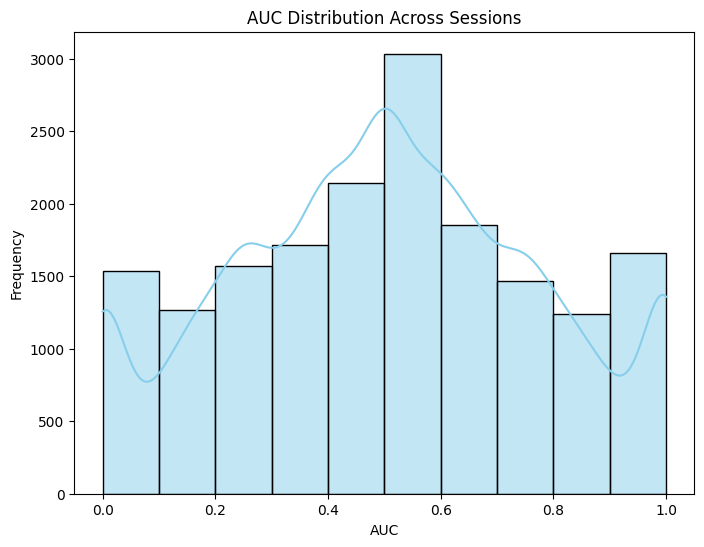

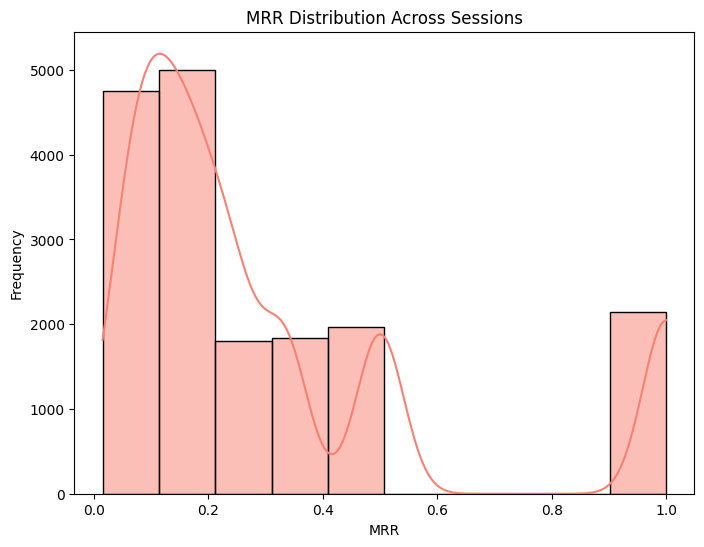

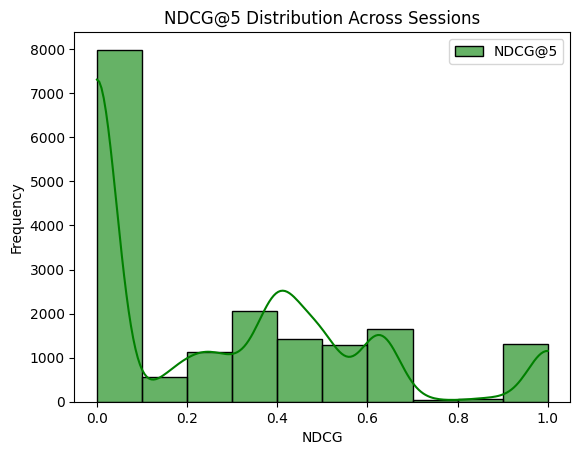

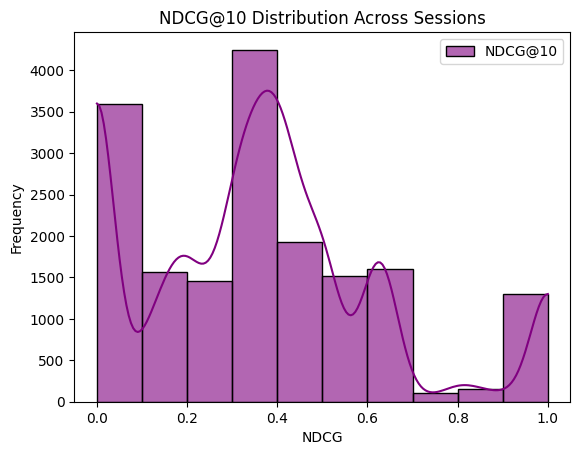

In [46]:
# Plot 1: Precision-Recall Curve for a sample session
def plot_precision_recall(data):
    precision, recall, _ = precision_recall_curve(data['clicked'], data['predicted_score'])
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

# Plot 2: AUC Distribution Across Sessions
plt.figure(figsize=(8, 6))
sns.histplot(results['AUC'], kde=True, color="skyblue", bins=10)
plt.title("AUC Distribution Across Sessions")
plt.xlabel("AUC")
plt.ylabel("Frequency")
plt.show()

# Plot 3: MRR Distribution
plt.figure(figsize=(8, 6))
sns.histplot(results['MRR'], kde=True, color="salmon", bins=10)
plt.title("MRR Distribution Across Sessions")
plt.xlabel("MRR")
plt.ylabel("Frequency")
plt.show()

# Plot 4: NDCG@5 and NDCG@10 Distributions
sns.histplot(results['NDCG@5'], kde=True, color="green", label="NDCG@5", bins=10, alpha=0.6)
plt.title("NDCG@5 Distribution Across Sessions")
plt.xlabel("NDCG")
plt.ylabel("Frequency")
plt.legend()
plt.show()


sns.histplot(results['NDCG@10'], kde=True, color="purple", label="NDCG@10", bins=10, alpha=0.6)
plt.title("NDCG@10 Distribution Across Sessions")
plt.xlabel("NDCG")
plt.ylabel("Frequency")
plt.legend()
plt.show()
